## Columnes
genre: The genre in which the track belongs.

artist_name: The artists' names who performed the track

track_name: Name of the track

track_id: The Spotify ID for the track

popularity: The popularity of a track is a value between 0 and 100

acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic

danceability: Danceability describes how suitable a track is for dancing based

duration_ms: The track length in milliseconds

energy: Measure of intensity and activity from 0.0 to 1.0

instrumentalness: Predicts whether a track contains no vocals (nearer 1=no vocals)

key: The key the track is in

liveness: Detects the presence of an audience in the recording (higher 0.8=live)

loudness: The overall loudness of a track in decibels (dB)

mode: Mode indicates the scale (major or minor) of a track

speechiness: Speechiness detects the presence of spoken words in a track

tempo: The overall estimated tempo of a track in beats per minute

time_signature: An estimated time signature

valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track

# A) Carregar llibreries

In [40]:
##A)Carregar llibreries
import pandas as pd ###py -m pip install pandas
import numpy as np ###py -m pip install numypy

from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD ###py -m pip install scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.cluster import KElbowVisualizer ##py -m pip install yellowbrick
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.manifold import TSNE
import seaborn as sns ##py -m pip install seaborn
import random
import matplotlib.pyplot as plt ##py -m pip install matplotlib


# B) Carregar dataset

In [41]:
##B)Carregar el dataset
df = pd.read_csv('SpotifyFeatures.csv')

df['__orig_idx'] = np.arange(len(df))
#print(f"Mostra: {df.head()}") #Mostra 5 rows
print(f"Info: {df.info()}") #Mostra el tipus de columns: df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

# C) Preparar dades

In [42]:
##C)Preparar dades
#1) Tractar duplicats
#Quantitat duplicats
print("Quantitat de dupplicats:", df.duplicated(subset="track_id", keep="first").sum())

#Treure duplicats (files)
df.drop_duplicates(subset="track_id", keep="first", inplace=True)
print("Quantitat de dupplicats després:", df.duplicated(subset="track_id", keep="first").sum())
print("New shape sense duplicats:", df.shape)

#Treure duplicats (files)
df.drop("genre", axis=1, inplace=True)
print("New shape sense genre:", df.shape)

Quantitat de dupplicats: 55951
Quantitat de dupplicats després: 0
New shape sense duplicats: (176774, 19)
New shape sense genre: (176774, 18)


In [43]:
#2) Corretgir valors errònis (impossibles)
#Comprovar valors de key, mode i time_signature
#print("Key values:", df['key'].value_counts())
#print("Mode values:", df["mode"].value_counts())
#print("Time_signature values:", df["time_signature"].value_counts())
#print("Genre values::", df["genre"].value_counts())

#Eliminar key: "0/4" (impossible)
print("Quantitat de '0/4'abans:", (df["time_signature"] == "0/4").sum()) #Quantitat key: "0/4"
df = df[df["time_signature"] != "0/4"]
print("Quantitat de '0/4' després:", (df["time_signature"] == "0/4").sum())
print("New shape sense '0/4':", df.shape)

#ALTERNATIVA
#Substituir 0/4 (impossible) per 4/4 (més comú)
#df["time_signature"] = df['time_signature'].replace('0/4','4/4')
#print("Nous valors de time_signature:", df["time_signature"].value_counts())

#Eliminar NaN
print("Quantitat de Nan abans:", df.isna().sum().sum()) #Quantitat Nan en tot df
#print("NaN per features:", df.isna().sum())
df.dropna(axis=0, inplace=True) #
print("Quantitat de Nan després:", df.isna().sum().sum())
print("New shape sense Nan:", df.shape)

Quantitat de '0/4'abans: 6
Quantitat de '0/4' després: 0
New shape sense '0/4': (176768, 18)
Quantitat de Nan abans: 1
 6
Quantitat de '0/4' després: 0
New shape sense '0/4': (176768, 18)
Quantitat de Nan abans: 1
Quantitat de Nan després: 0
New shape sense Nan: (176767, 18)
Quantitat de Nan després: 0
New shape sense Nan: (176767, 18)


In [44]:
#3) Eliminar columnes innecesàries
# Guardar track_name y artist_name antes de eliminarlas (las usaremos después)
track_names_backup = df['track_name'].copy()
artist_names_backup = df['artist_name'].copy()

#Drop olumnes: 'artist_name','track_name','track_id 
df.drop(['artist_name','track_name','track_id'], axis=1, inplace=True) #Elimina les columnes modificant df og
print(f"Nova shape sense artist_name, track_name, track_id: {df.shape}") #Mostra rowsxcolumns


Nova shape sense artist_name, track_name, track_id: (176767, 15)


In [45]:
#4)Codificar columnes no numèriques
#Diccionaris codificació valors únics
#METODE1
"""
mode_dict = {'Major' : 1, 'Minor' : 0}
key_dict = {'C' : 1, 'C#' : 2, 'D' : 3, 'D#' : 4, 'E' : 5, 'F' : 6, 
        'F#' : 7, 'G' : 9, 'G#' : 10, 'A' : 11, 'A#' : 12, 'B' : 12}
time_signature_dict = {'1/4' : 1, '3/4' : 3, '4/4' :4, "5/4": 5}

#Codificar columna key 
df["key"] = df["key"].map(key_dict)

#Codificar columna mode 
df["mode"] = df["mode"].map(mode_dict)

#Codificar columna time_signature
df["time_signature"] = df["time_signature"].map(time_signature_dict)
"""

#METODE2
"""
freq = df["key"].value_counts(normalize=True)
df["key"] = df["key"].map(freq)
#Codificar columna mode 
freq = df["mode"].value_counts(normalize=True)
df["mode"] = df["mode"].map(freq)
#Codificar columna time_signature
freq = df["time_signature"].value_counts(normalize=True)
df["time_signature"] = df["time_signature"].map(freq)
"""
#METODE3 OneHotEncoder 

df_temp = df[['key', 'mode', 'time_signature']].copy()
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = enc.fit_transform(df_temp)

feature_names = enc.get_feature_names_out(['key', 'mode', 'time_signature'])
encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df.index)

df = pd.concat([df.drop(['key', 'mode', 'time_signature'], axis=1), encoded_df], axis=1)

print(f"Nova shape després de OneHotEncoder: {df.shape}")
print(f"Noves columnes: {df.columns.tolist()}")

Nova shape després de OneHotEncoder: (176767, 30)
Noves columnes: ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', '__orig_idx', 'key_A', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'mode_Major', 'mode_Minor', 'time_signature_4-1月', 'time_signature_4-3月', 'time_signature_4-4月', 'time_signature_4-5月']


array([[<Axes: title={'center': 'popularity'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'duration_ms'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'tempo'}>],
       [<Axes: title={'center': 'valence'}>,
        <Axes: title={'center': '__orig_idx'}>,
        <Axes: title={'center': 'key_A'}>,
        <Axes: title={'center': 'key_A#'}>,
        <Axes: title={'center': 'key_B'}>],
       [<Axes: title={'center': 'key_C'}>,
        <Axes: title={'center': 'key_C#'}>,
        <Axes: title={'center': 'key_D'}>,
        <Axes: title={'center': 'key_D#'}>,
        <Axes: title={'center': 'key_E'}>],
       [<Axes: title={'center': 'key_F'}>,
        <Axes: title={'center': 'k

d:\Aplicaciones\Anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  func(*args, **kwargs)
d:\Aplicaciones\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Aplicaciones\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


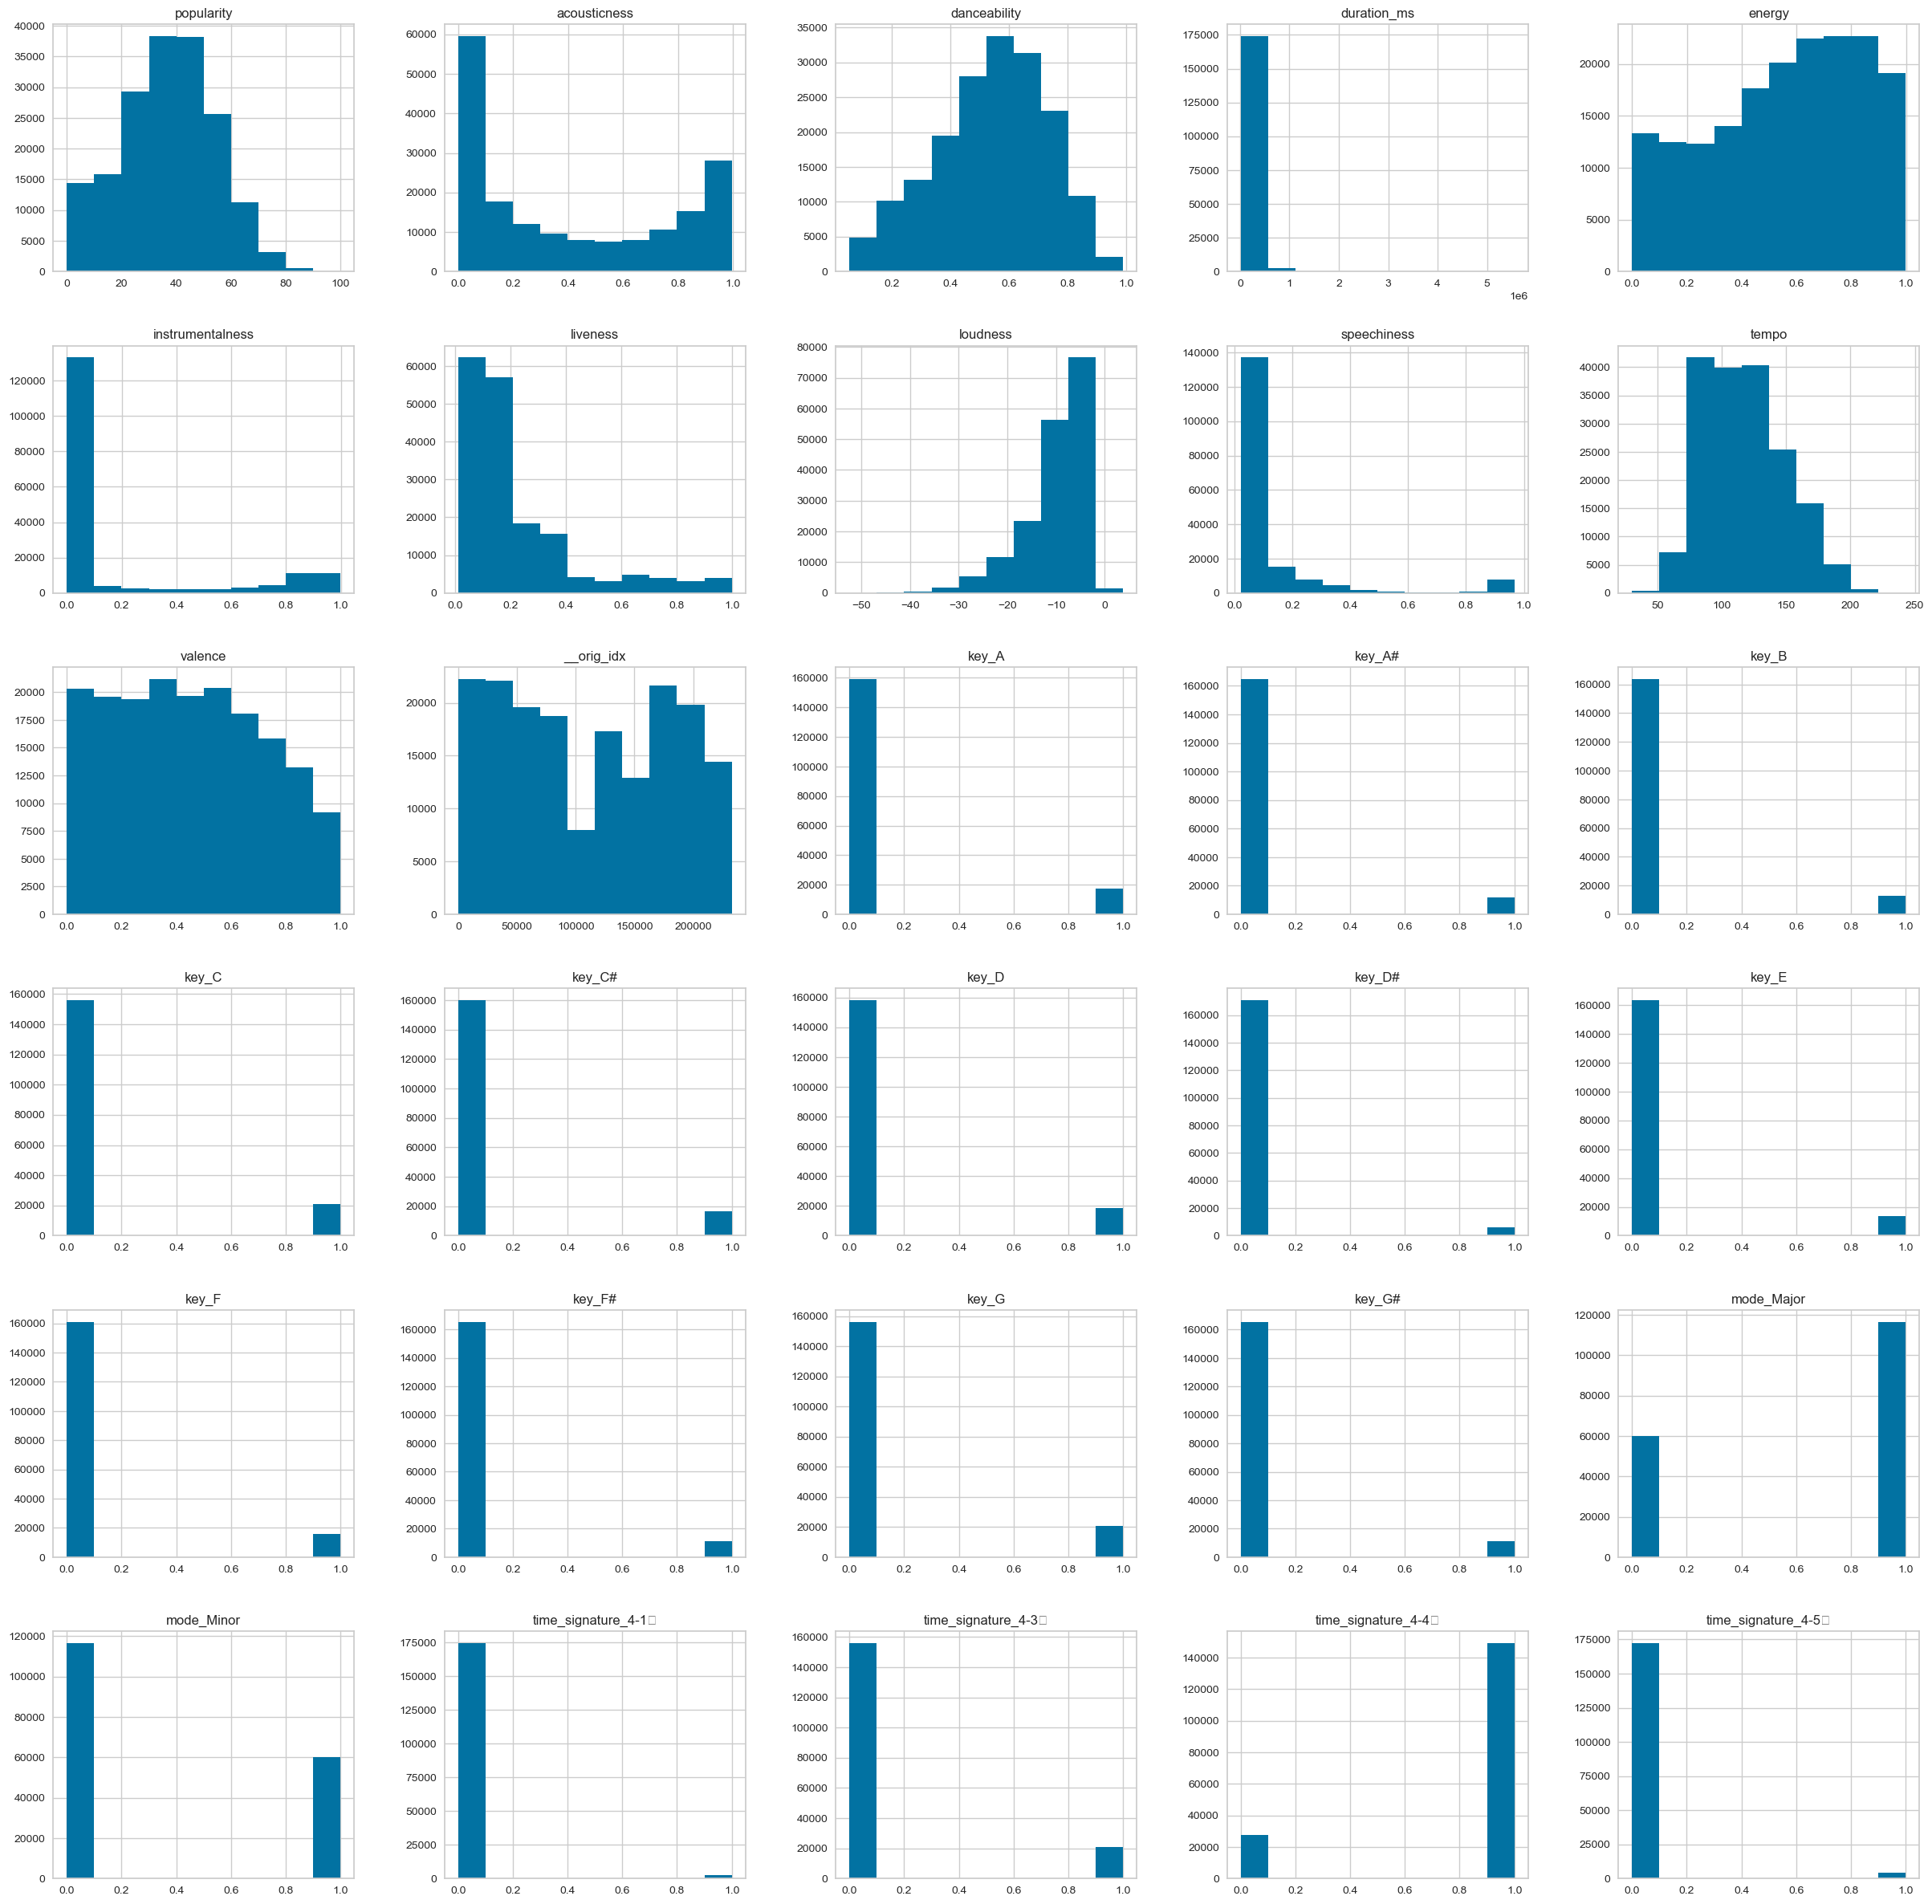

In [46]:
#5) Mirar dist
df.hist(figsize=(30, 30))

d:\Aplicaciones\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.draw()
d:\Aplicaciones\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Aplicaciones\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


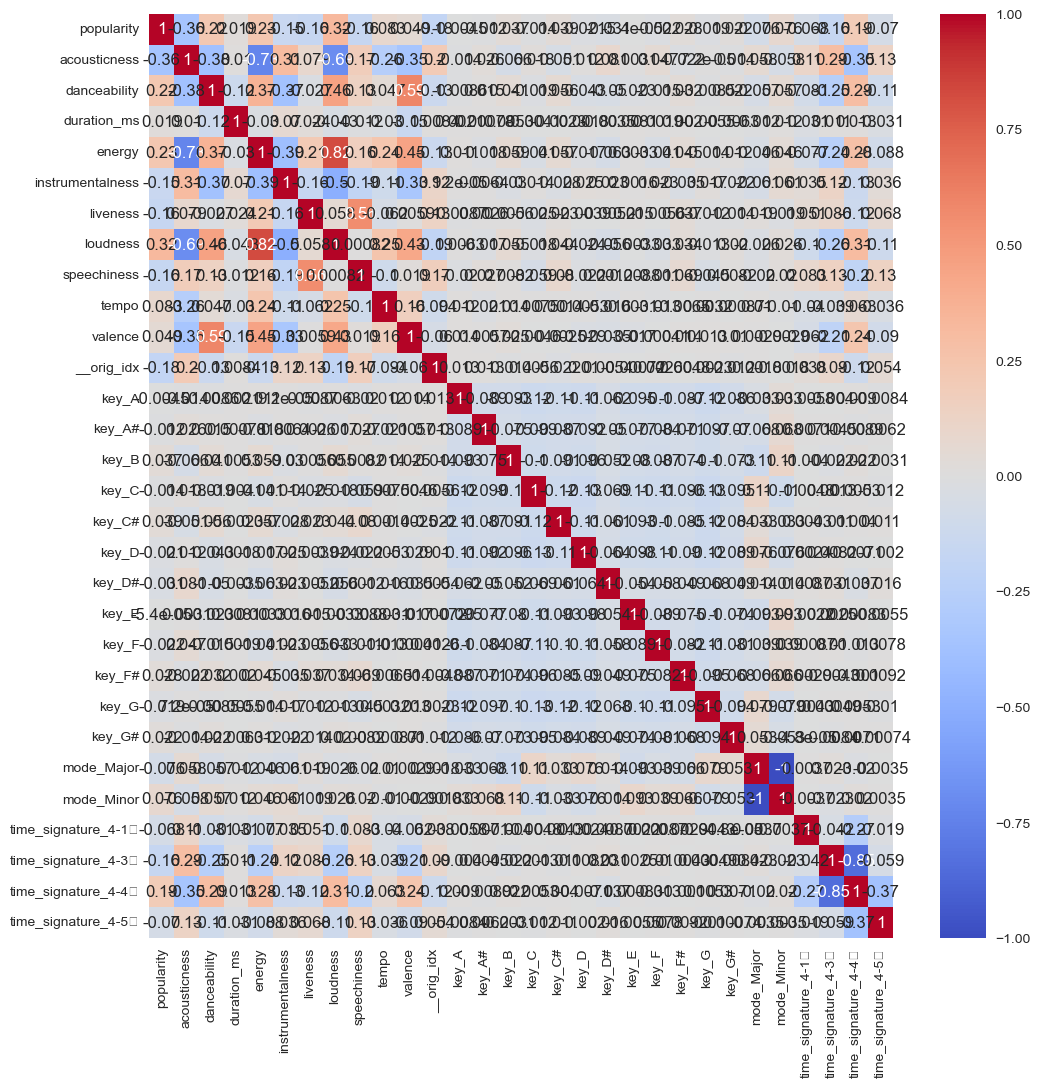

In [47]:
#5) Mirar correlació (pearson)
corr_matrix = df.corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# D) Establir model

In [48]:
#1) Copiar df
# Guardar array d'índex original i separar-lo de les features per a l'escalat
orig_idx_array = df['__orig_idx'].to_numpy()

data = df.drop(columns=['__orig_idx']).copy()
print("Info:")
print(data.info())

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 176767 entries, 0 to 232724
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   popularity           176767 non-null  int64  
 1   acousticness         176767 non-null  float64
 2   danceability         176767 non-null  float64
 3   duration_ms          176767 non-null  int64  
 4   energy               176767 non-null  float64
 5   instrumentalness     176767 non-null  float64
 6   liveness             176767 non-null  float64
 7   loudness             176767 non-null  float64
 8   speechiness          176767 non-null  float64
 9   tempo                176767 non-null  float64
 10  valence              176767 non-null  float64
 11  key_A                176767 non-null  float64
 12  key_A#               176767 non-null  float64
 13  key_B                176767 non-null  float64
 14  key_C                176767 non-null  float64
 15  key_C#          

In [49]:
#3) Fer amb Scaler (mateix rang totes feature)
scaler = StandardScaler()
data_scal = scaler.fit_transform(data)
#data_scal = pd.DataFrame(data=scaler.fit_transform(data), columns=data.columns)

In [50]:
"""
#2) Calcular k millor
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric='distortion')
visualizer.fit(data)       
#visualizer.show()        
k = visualizer.elbow_value_ #millor k

#4) Entrenar i predir amb KMEANS
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
pred = kmeans.fit_predict(data_scal)
#data_scal["cluster"] = pred
"""

'\n#2) Calcular k millor\nmodel = KMeans()\nvisualizer = KElbowVisualizer(model, k=(2,30), timings=False, metric=\'distortion\')\nvisualizer.fit(data)       \n#visualizer.show()        \nk = visualizer.elbow_value_ #millor k\n\n#4) Entrenar i predir amb KMEANS\nkmeans = KMeans(n_clusters=k, n_init=10, random_state=0)\npred = kmeans.fit_predict(data_scal)\n#data_scal["cluster"] = pred\n'

In [51]:
#4) Entrenar i predir amb DBSCAN
#db = HDBSCAN(min_cluster_size=15, min_samples=5)
"""
db = DBSCAN(eps=0.42, min_samples=5, n_jobs=-1,)
pred = db.fit_predict(data_scal)
labels = db.labels_
print(f"Etiquetes trobades (incloent -1 per soroll): {set(labels)}")
print(f"Nombre de clusters (sense comptar -1): {len(set(labels) - {-1})}")"""


'\ndb = DBSCAN(eps=0.42, min_samples=5, n_jobs=-1,)\npred = db.fit_predict(data_scal)\nlabels = db.labels_\nprint(f"Etiquetes trobades (incloent -1 per soroll): {set(labels)}")\nprint(f"Nombre de clusters (sense comptar -1): {len(set(labels) - {-1})}")'

In [52]:
## G.1) Crear sampled dataset per proves més ràpides
# Samplearem 10% de les dades per a proves
sample_size = int(len(data_scal) * 0.1)
sample_indices = np.random.RandomState(42).choice(len(data_scal), sample_size, replace=False)
data_scal_sample = data_scal[sample_indices]

print(f"Tamany original: {data_scal.shape}")
print(f"Tamany sampled (10%): {data_scal_sample.shape}")


Tamany original: (176767, 29)
Tamany sampled (10%): (17676, 29)


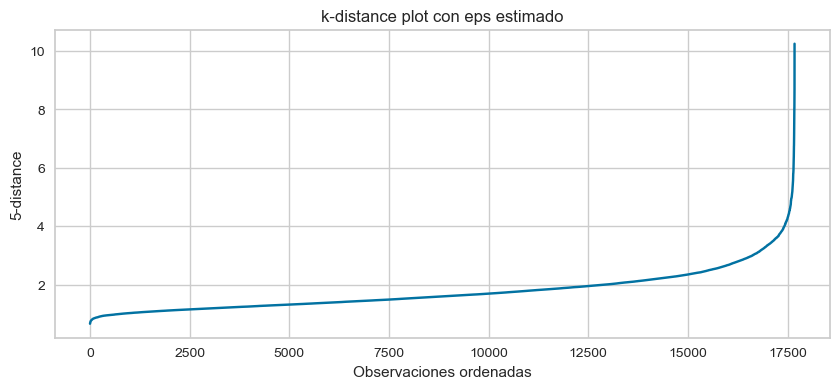

Etiquetes trobades: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -1}


In [53]:
# I) DBSCAN rápido: seleccionar eps automáticamente (curvatura en k-distance) y ejecutar
# k-distance
k = 5
nn = NearestNeighbors(n_neighbors=k).fit(data_scal_sample)
dists, _ = nn.kneighbors(data_scal_sample)
kdist = np.sort(dists[:, -1])
plt.figure(figsize=(10,4))
plt.plot(kdist, label=f'{k}-distance sorted')
plt.title('k-distance plot con eps estimado')
plt.xlabel('Observaciones ordenadas')
plt.ylabel(f'{k}-distance')
plt.show()
db = DBSCAN(eps=3.8, min_samples=54, n_jobs=-1,)
pred = db.fit_predict(data_scal_sample)
labels = db.labels_
print(f"Etiquetes trobades: {set(labels)}")

# E) Proves amb sampled data i altres kernels


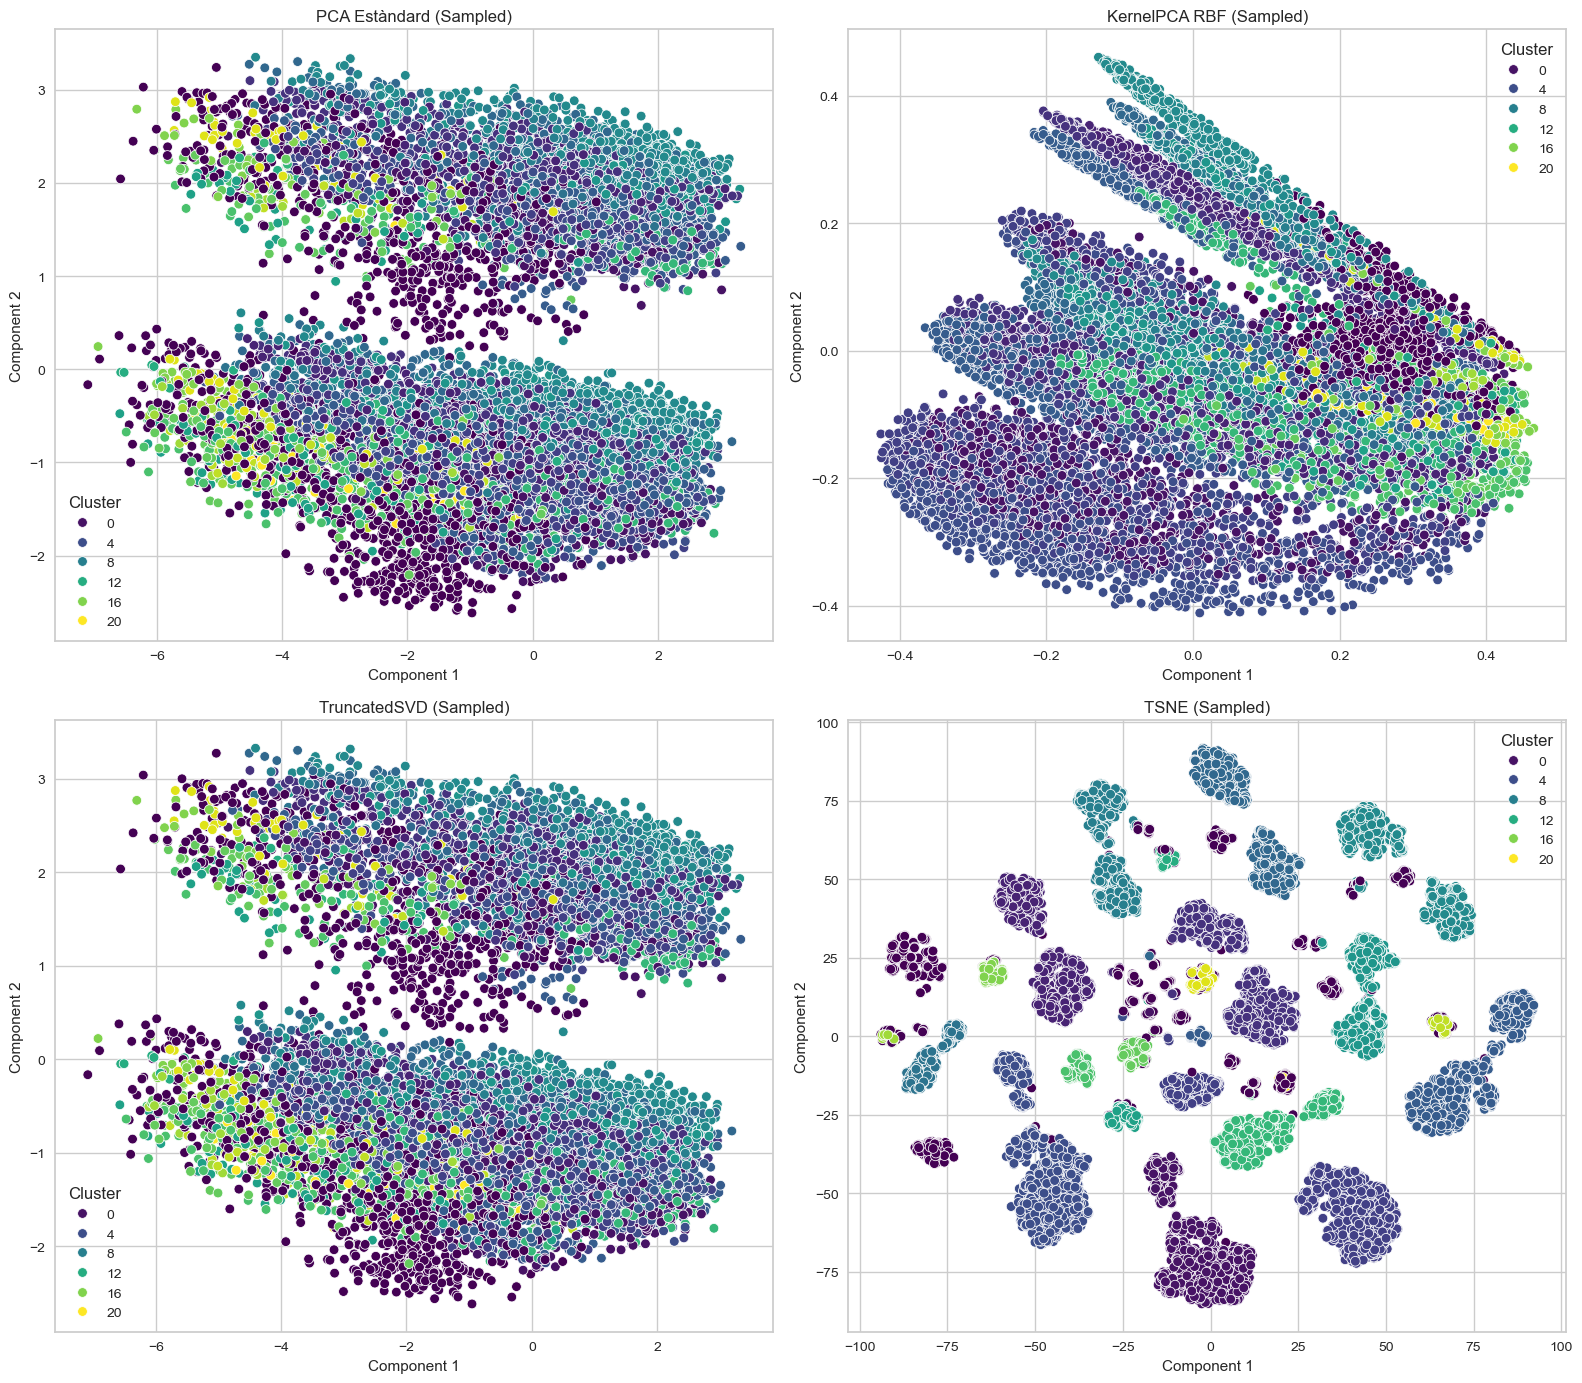

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
# 1. PCA Estàndard
pca_sample = PCA(n_components=2, random_state=42)
data_pca_sample = pca_sample.fit_transform(data_scal_sample)

pca_sample_df = pd.DataFrame(data=data_pca_sample, columns=['Component 1', 'Component 2'])
pca_sample_df["Cluster"] = pred
sns.scatterplot(data=pca_sample_df, x='Component 1', y='Component 2', hue='Cluster', 
               palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('PCA Estàndard (Sampled)')

# 2. KernelPCA RBF
kpca_sample = KernelPCA(n_components=2, kernel='rbf', random_state=42, n_jobs=-1)
data_kpca_sample = kpca_sample.fit_transform(data_scal_sample)

kpca_sample_df = pd.DataFrame(data=data_kpca_sample, columns=['Component 1', 'Component 2'])
kpca_sample_df["Cluster"] = pred
sns.scatterplot(data=kpca_sample_df, x='Component 1', y='Component 2', hue='Cluster', 
               palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('KernelPCA RBF (Sampled)')

# 3. TruncatedSVD
tsvd_sample = TruncatedSVD(n_components=2, random_state=42)
data_tsvd_sample = tsvd_sample.fit_transform(data_scal_sample)

tsvd_sample_df = pd.DataFrame(data=data_tsvd_sample, columns=['Component 1', 'Component 2'])
tsvd_sample_df["Cluster"] = pred
sns.scatterplot(data=tsvd_sample_df, x='Component 1', y='Component 2', hue='Cluster', 
               palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('TruncatedSVD (Sampled)')

# 4. KernelPCA Polynomial
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=42)
data_tsne = tsne.fit_transform(data_scal_sample)
data_tsne_sample_df = pd.DataFrame(data=data_tsne, columns=['Component 1', 'Component 2'])
data_tsne_sample_df["Cluster"] = pred

sns.scatterplot(data=data_tsne_sample_df, x='Component 1', y='Component 2', hue='Cluster', 
               palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('TSNE (Sampled)')

plt.tight_layout()
plt.show()


In [55]:
# J) Obtener track_name de dos nodos aleatorios del mismo cluster (con mapeo seguro)
# Excluir ruido (-1) y obtener clusters disponibles
cluster_labels = sorted([c for c in set(labels) if c != -1])

if len(cluster_labels) == 0:
    print('No hay clusters disponibles (solo ruido).')
else:
    sizes = {c: int((labels == c).sum()) for c in cluster_labels}
    chosen_cluster = max(sizes, key=sizes.get)
    positions = np.where(labels == chosen_cluster)[0]
    
    if len(positions) >= 2:
        sel_positions = np.random.choice(positions, size=2, replace=False)
        
        # Mapear posiciones en data_scal_sample -> índices originales usando sample_indices y orig_idx_array
        # sample_indices contiene las filas originales de data_scal que fueron sampleadas
        orig_positions = orig_idx_array[sample_indices[sel_positions]]
        
        track_names = track_names_backup.iloc[orig_positions].values
        artists = artist_names_backup.iloc[orig_positions].values
        
        print(f"\nCluster elegido: {chosen_cluster} (tamaño = {len(positions)})")
        print(f"Posiciones en sample: {sel_positions}")
        print(f"Índices originales: {orig_positions}")
        print('Dos tracks aleatorios del mismo cluster:')
        for i, (tn, an) in enumerate(zip(track_names, artists), start=1):
            print(f"  {i}. {tn} - {an}")
    else:
        print(f'Cluster {chosen_cluster} tiene menos de 2 elementos.')



Cluster elegido: 4 (tamaño = 1706)
Posiciones en sample: [16835  1062]
Índices originales: [168019  18659]
Dos tracks aleatorios del mismo cluster:
  1. Still Doin' Time - George Jones
  2. Everywhere You Look (The Fuller House Theme) - Carly Rae Jepsen
